# Implementation

## DeepXDE

In [ ]:
'''
First of all we are going to install all the depedencies.
(Matplotlib, Numpy, Scikit Learn, Scikit Optimize and SciPy)
'''
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install scikit-optimize
!pip install scipy

### TensorFlow

In [2]:
'''
Now we need to install from pip the backend library and the backend in this case we will
use Tensorflow2.x and then we will install DeepXDE also from pip.
'''
!pip install upgrade pip
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
Defaulting to user installation because normal site-packages is not writeable


In [2]:
'''
Now we will install DeepXDE library
'''
!pip install deepxde

Defaulting to user installation because normal site-packages is not writeable


## Ejemplo

Compiling model...
Building feed-forward neural network...
'build' took 0.710296 s

'compile' took 3.597880 s

Training model...

Step      Train loss                                            Test loss                                             Test metric   
0         [1.59e+01, 9.50e-01, 2.75e-01, 3.92e-01, 2.28e+00]    [1.68e+01, 9.50e-01, 2.75e-01, 3.92e-01, 2.28e+00]    [2.39e+00]    
INFO:tensorflow:best_model.ckpt-100.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch 100: test loss improved from inf to 2.07e+01, saving model to best_model.ckpt-100.ckpt ...

1000      [1.65e-01, 1.59e-01, 2.93e-02, 9.20e-02, 3.54e-01]    [1.15e-01, 1.59e-01, 2.93e-02, 9.20e-02, 3.54e-01]    [8.19e-01]    
INFO:tensorflow:best_model.ckpt-1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Epoch 1000: test loss improved from 2.07e+01 to 7.50e-01, saving model to best_model.ckpt-1000.ckpt ...

2000      [2.12e-02, 1.11e-01, 4.56e-02, 8.15e-02, 2.96e-01]    [1.74

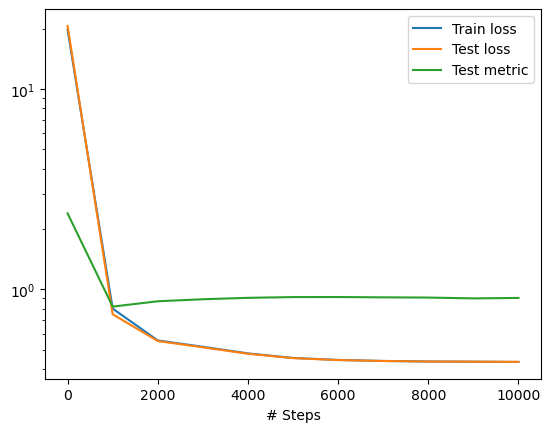

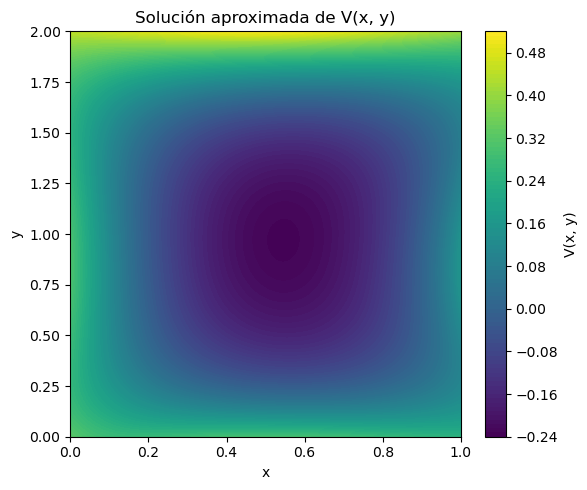

Saving loss history to /home/darkenis/Programs/Repositories/PinnsMFC/implementation/loss.dat ...
Saving training data to /home/darkenis/Programs/Repositories/PinnsMFC/implementation/train.dat ...
Saving test data to /home/darkenis/Programs/Repositories/PinnsMFC/implementation/test.dat ...


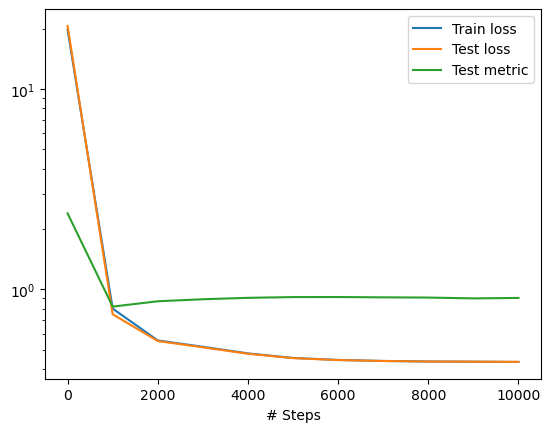

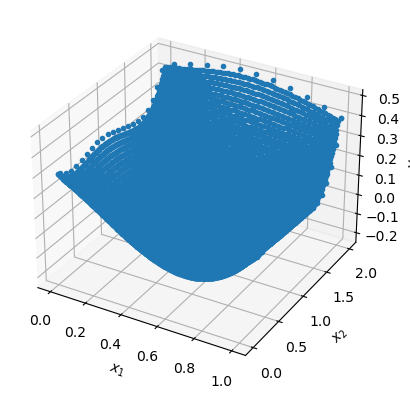

In [17]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt
from deepxde import backend as bkd

# Definir el dominio rectangular
geom = dde.geometry.Rectangle([0, 0], [1, 2])  # x ∈ [0, 1], y ∈ [0, 2]

# Definir la ecuación de Poisson: ∇²V = 4
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return dy_xx + dy_yy - 4

# Condiciones de frontera
def boundary_left(x, on_boundary): # Frontera izquierda: x = 0
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary): # Frontera derecha: x = 1
    return on_boundary and np.isclose(x[0], 1)

def boundary_bottom(x, on_boundary): # Frontera inferior: y = 0
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary): # Frontera superior: y = 2
    return on_boundary and np.isclose(x[1], 2)


# Definir condiciones de frontera (Dirichlet)
# En x = 0 (tu aclaración "x=1 es en realidad x=0"): V(0,y) = (0-y)^2 = y^2
bc_left = dde.DirichletBC(geom, lambda x: x[1]**2, boundary_left)

# En x = 1 (interpretado como "x=2" en la imagen, para tu dominio): V(1,y) = (1-y)^2
# Nota: (y-1)^2 es lo mismo que (1-y)^2
bc_right = dde.DirichletBC(geom, lambda x: (1 - x[1])**2, boundary_right)

# En y = 0: V(x,0) = (x-0)^2 = x^2
bc_bottom = dde.DirichletBC(geom, lambda x: x[0]**2, boundary_bottom)

# En y = 2: V(x,2) = (x-2)^2
bc_top = dde.DirichletBC(geom, lambda x: (x[0] - 2)**2, boundary_top)

# Solución exacta para evaluar el error
def exact_solution(x):
    return ((x[:, 0] - x[:, 1])**2).reshape(-1, 1)
# Preparar el problema
data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_right, bc_bottom, bc_top], # Usar las BCs corregidas
    num_domain=256,
    num_boundary=64,
    solution=exact_solution,
    num_test=10000,
)

# Red neuronal
net = dde.maps.FNN([2] + [64] + [64] + [64] + [1], activation=bkd.tanh, kernel_initializer=tf.keras.initializers.he_normal())

# Modelo
model = dde.Model(data, net)

# --- CONFIGURACIÓN DEL CALLBACK ModelCheckpoint ---
model_save_path = "best_model.ckpt"
callbacks = [
    dde.callbacks.ModelCheckpoint(
        model_save_path,
        # CAMBIO AQUÍ: Monitorear la pérdida del conjunto de prueba
        monitor="test loss",
        verbose=1,
        save_better_only=True,
        period=100 # Revisa y guarda cada 100 épocas
    )
]

# --- ESTRATEGIA DE ENTRENAMIENTO MEJORADA ---
# 1. Entrenar con Adam para una convergencia inicial rápida
# Asegúrate de que DeepXDE sepa que hay un conjunto de prueba para evaluar la métrica.
# Aunque no monitorees "l2 relative error" directamente en el callback,
# es bueno que la compiles para que DeepXDE la calcule y la muestre en el historial de pérdida.
model.compile("adam", lr=1e-4, metrics=["MSE"])
losshistory, train_state = model.train(epochs=10000, callbacks=callbacks)


# Si quieres guardar el modelo final después de L-BFGS-B, puedes hacerlo explícitamente:
model.save("final_model.ckpt")

# Evaluar el error L2 con la solución exacta
X_test = data.test_points()  # ← Añade los paréntesis aquí
l2_error = dde.metrics.l2_relative_error(
    exact_solution(X_test), model.predict(X_test)
)
print(f"\nError relativo L2: {l2_error:.4e}")

# Graficar el historial de pérdida
dde.utils.plot_loss_history(losshistory)


# (Opcional) Graficar la solución en una cuadrícula
X, Y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
XY = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
V_pred = model.predict(XY).reshape(100, 100)

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, V_pred, levels=100, cmap="viridis")
plt.colorbar(label="V(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solución aproximada de V(x, y)")
plt.tight_layout()
plt.show()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Pytorch

In [2]:
"""
Now we want to use the pytorch backend, for that propousal we are going to install the library using pip as follow: 
"""
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28

In [ ]:
"""
we can implement the lbrary with another PDE example:
"""